<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/NB11.%20Medical%20Instance%20Segmentation%20with%20Mask%20RCNN%20Custom%20Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Instance Segmentation with Mask RCNN Custom Finetuning.


## 1. Introduction

Mask R-CNN, an extension of [Faster R-CNN](http://paperswithcode.com/method/faster-r-cnn), enhances its predecessor's capabilities by incorporating a dedicated branch for predicting instance masks alongside the existing bounding box recognition mechanism. This modification enables Mask R-CNN to perform both object detection and pixel-level segmentation within a unified framework, making it a versatile tool for tasks requiring precise object delineation.

Faster R-CNN, initially designed primarily for accurate object localization using region proposal networks (RPNs) and [RoIPool](http://paperswithcode.com/method/roi-pooling) for feature extraction, faced challenges in maintaining pixel-to-pixel alignment due to its coarse spatial quantization approach. This limitation becomes particularly apparent in tasks like instance segmentation, where exact spatial fidelity is critical.

To overcome this, Mask R-CNN introduces [RoIAlign](http://paperswithcode.com/method/roi-align), a refined operation that preserves precise spatial locations during feature extraction from region of interest (RoI) proposals. By eliminating the quantization step present in RoIPool, RoIAlign ensures that the features used for mask prediction align accurately with the corresponding regions in the input image, thereby improving segmentation quality significantly.

### Dataset Overview: NuInsSeg

The [**NuInsSeg dataset**](https://www.kaggle.com/datasets/ipateam/nuinsseg/data) stands out as a comprehensive resource designed specifically for advancing semantic and instance segmentation tasks in histopathology. It comprises over 30,000 manually segmented nuclei originating from 31 different organs of human and mouse subjects, annotated from high-resolution H&E-stained whole slide images. These annotations serve as a foundational dataset for training and evaluating segmentation algorithms.

In addition to nuclei annotations, the dataset includes 665 image patches extracted from these whole slide images, encapsulating a wide range of tissue types and morphologies. This diversity ensures that segmentation models trained on NuInsSeg are robust and capable of handling various biological contexts.

One of the unique features of the NuInsSeg dataset is the provision of ambiguous area masks, which highlight regions where manual segmentation was deemed challenging or impractical. These masks offer insights into the complexities and nuances involved in real-world segmentation tasks, aiding in the development of more robust and generalizable segmentation algorithms.

Overall, the NuInsSeg dataset not only supports the development and benchmarking of instance segmentation algorithms but also contributes significantly to the advancement of automated histopathological analysis, potentially enhancing medical diagnostics and research outcomes.


---
**Install Kaggle API Library**

---

In [1]:
!rm -rf /content/dataset-Nuclei
%pip install -q kaggle


---

**Upload your Kaggle API Key**

---

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


---

**Copy the API key to `~/.kaggle`**

---

In [3]:
# %%capture # util quieres capturar el output de la celda
%mkdir -p ~/.kaggle
%cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~

total 72
drwx------ 1 root root 4096 Jul 20 07:44 .
drwxr-xr-x 1 root root 4096 Jul 20 07:36 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Jul 18 13:39 .cache
drwxr-xr-x 3 root root 4096 Jul 18 13:39 .config
drwxr-xr-x 5 root root 4096 Jul 18 13:39 .ipython
drwx------ 1 root root 4096 Jul 18 13:39 .jupyter
drwxr-xr-x 2 root root 4096 Jul 20 07:44 .kaggle
drwxr-xr-x 2 root root 4096 Jul 20 07:37 .keras
drwx------ 3 root root 4096 Jul 18 13:14 .launchpadlib
drwxr-xr-x 1 root root 4096 Jul 18 13:39 .local
drwxr-xr-x 4 root root 4096 Jul 18 13:39 .npm
-rw-r--r-- 1 root root  161 Jul  9  2019 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf
-rw-r--r-- 1 root root  211 Jul 18 13:39 .wget-hsts


---
**List kaggle datasets nuiseng**

---

In [4]:
!kaggle datasets list -s "nuinsseg"

ref               title     size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------  --------  ----  -------------------  -------------  ---------  ---------------  
ipateam/nuinsseg  NuInsSeg   2GB  2023-06-12 14:49:00            833         15  0.875            


---

**Download ipateam/nuinsseg**

---


In [5]:
%%time
# Download the dataset from Kaggle (2m.)

from  zipfile import ZipFile
import os

# First, ensure the 'dataset-Nuclei' directory exists

!mkdir -p ./dataset-Nuclei

# Download the dataset from Kaggle in dataset-Nuclei

!kaggle datasets download -d ipateam/nuinsseg -p ./dataset-Nuclei

# Unzip the dataset into the 'dataset-Nuclei' directory

with ZipFile('./dataset-Nuclei/nuinsseg.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset-Nuclei')

# or simply
#!unzip ./dataset-Nuclei/nuinsseg.zip -d ./dataset-Nuclei -q

# Remove the zip file after extraction (optional)

os.remove('./dataset-Nuclei/nuinsseg.zip')


Dataset URL: https://www.kaggle.com/datasets/ipateam/nuinsseg
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.51G/1.52G [00:21<00:00, 121MB/s] 
100% 1.52G/1.52G [00:21<00:00, 76.2MB/s]
CPU times: user 12.4 s, sys: 4.63 s, total: 17 s
Wall time: 43 s


---
**List our directory dataset-Nuclei**

---


In [6]:
# Install Pip Tree globally

!sudo apt install tree -q


!tree --dirsfirst -L 2  "dataset-Nuclei"

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (123 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 123586 files and directories currently installed.)
Preparing 

## 2. Data Preparation


Clean up of the Nuclei dataset
Can be downloaded from: https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download

The dataset comes with a lot of subdirectories that can be very useful depending
on the task of your interest. For our Mask RCNN and Ultralytics training, we just
need the raw images and labeled masks that we will convert to appropriate formats.
So let us delete all unwanted data and keep only the raw images, binary masks
and label masks.

Keep the directories with names `'tissue images'`, `'mask binary without border'`, and `'label masks modify'`.

---

**Pruning innecesary sub-subdirectories**

---

In [7]:
import os
import shutil

base_directory = "dataset-Nuclei"
directories_to_keep = ['tissue images',
                       'mask binary without border',
                       'label masks modify']

#Iterate through each subdirs in base dir
for root_dir in os.listdir(base_directory):
  root_path = os.path.join(base_directory,root_dir)
  if os.path.isdir(root_path):
        # print(f"Processing: {root_path}")
    #List all subdirs inside the current root dir
    for sub_dir in os.listdir(root_path):
      sub_path = os.path.join(root_path, sub_dir)
      #If the subdirectory isn't in the keep list, delete it
      if os.path.isdir(sub_path) and sub_dir not in directories_to_keep:
        # print(f"Deleting: {sub_path}")
        shutil.rmtree(sub_path)
      elif os.path.isdir(sub_path):
        # print(f"Keeping: {sub_path}")
        pass



---


**List prunned directory**



---



In [8]:
!tree --dirsfirst -L 2  "dataset-Nuclei"

dataset-Nuclei
├── human bladder
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human brain
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cardia
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human cerebellum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human epiglottis
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human jejunum
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human kidney
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human liver
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human lung
│   ├── label masks modify
│   ├── mask binary without border
│   └── tissue images
├── human melanoma
│   ├── label masks modify
│   ├── mask binary with

## 3. Displaying Images from Dataset

Next code selects a certain number of images from a directory containing images of `tissue`, calculates the appropriate layout for subplots based on the number of images, and displays the images in the subplots using matplotlib.

---

**Display some images from dataset**

---


 Displaying images from dataset-Nuclei/mouse heart/label masks modify 



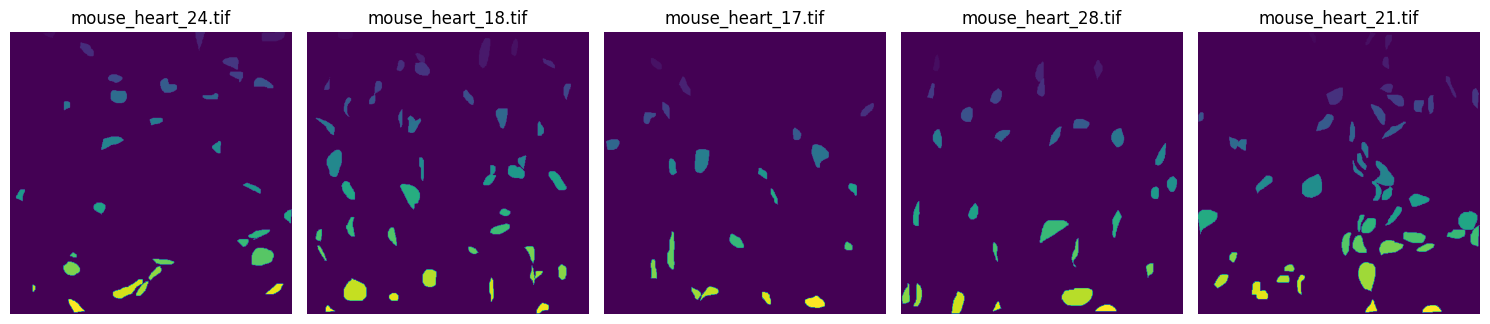


 Displaying images from dataset-Nuclei/mouse heart/tissue images 



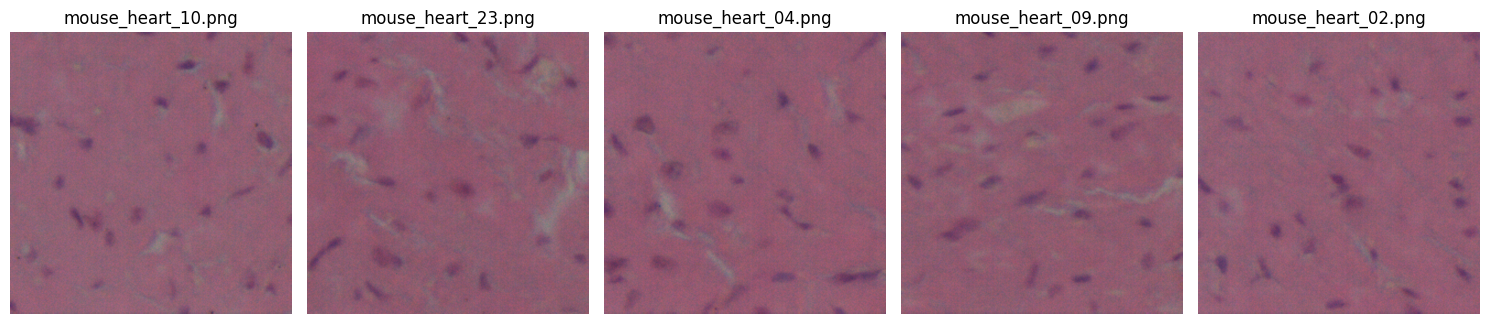


 Displaying images from dataset-Nuclei/mouse heart/mask binary without border 



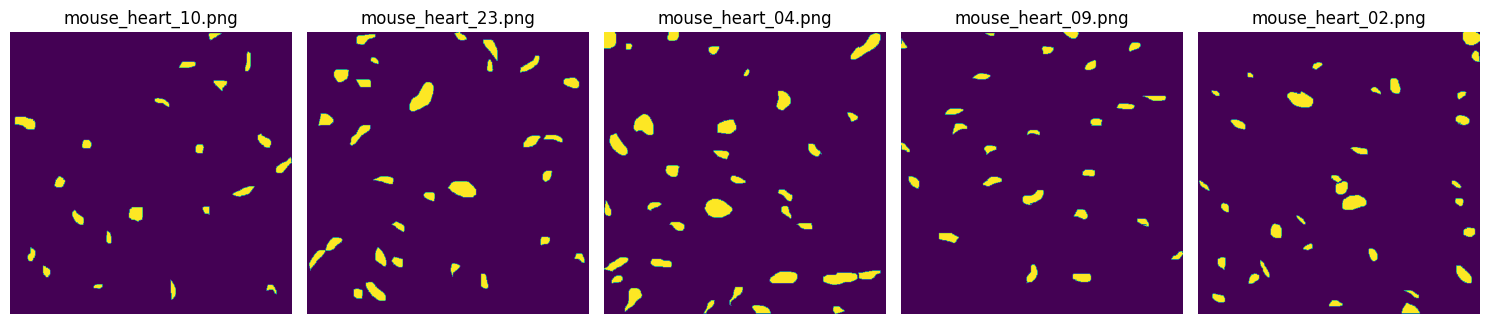

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Select a random subdirectory from subdirectories
random_subdirectory = random.choice(subdirectories)
random_subdirectory_path = os.path.join(base_directory, random_subdirectory)

# List of sub-subdirectories in the random subdirectory
subsubdirectories = [d for d in os.listdir(random_subdirectory_path) if os.path.isdir(os.path.join(random_subdirectory_path, d))]

# Function to display images from a directory
def display_images_from_directory(directory, max_images=5):
    image_extensions = ['.tif', '.png']
    image_files = [f for f in os.listdir(directory) if any(f.endswith(ext) for ext in image_extensions)]

    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(image_files[:max_images]):  # Displaying up to max_images
        img_path = os.path.join(directory, image_file)
        img = Image.open(img_path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images from each sub-subdirectory
for subsubdirectory in subsubdirectories:
    subsubdirectory_path = os.path.join(random_subdirectory_path, subsubdirectory)
    print(f"\n Displaying images from {subsubdirectory_path} \n")
    display_images_from_directory(subsubdirectory_path)


We need to convert Label Masks to Coco Json single file annotation. We will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

For it we will use

The get_image_mask_pairs function traverses a data directory, finds all PNG images in directories that contain 'tissue images', and builds a list of their paths along with the paths of their corresponding masks, assuming the masks are in a parallel directory named 'label masks modify' and have a '.tif' extension. This function is useful for preparing pairs of image and mask data for further processing or analysis.



The mask_to_polygons function processes a binary mask to extract contours, reshapes these contours into polygons (a flat list of coordinates), and ensures that each polygon has a valid number of points. This is useful for converting segmentation masks into a format suitable for COCO annotations or other applications that require polygon representations of objects.

This code processes all images in the subdirectories and sub-subdirectories of the base directory, checks if they are binary, extracts polygons from the contours, and generates a coco.json file with the corresponding annotations.

---

**Mask_to_polygons_to COCO.json**

---

In [10]:
%%time
import os
import json
import numpy as np
import cv2
from PIL import Image

# Directory containing images
base_directory = "dataset-Nuclei"

# List of subdirectories in the base directory
subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# Function to check if an image is binary
def is_binary_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_np = np.array(img)
    unique_values = np.unique(img_np)
    return len(unique_values) == 2 and set(unique_values).issubset({0, 255})

# Function to find contours in a binary image and convert them to polygons
def get_polygons_from_mask(mask_image):
    mask_np = np.array(mask_image)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [contour.flatten().tolist() for contour in contours if len(contour) >= 3]
    return polygons

# Initialize COCO structure
coco_data = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "nucleus", "supercategory": "object"}]
}

annotation_id = 1

# Process each subdirectory and its sub-subdirectories
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(base_directory, subdirectory)
    subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]

    for subsubdirectory in subsubdirectories:
        subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
        image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.tif', '.png'])]

        for image_file in image_files:
            img_path = os.path.join(subsubdirectory_path, image_file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale

            if is_binary_image(img_path):
                img_np = np.array(img)
                height, width = img_np.shape
                polygons = get_polygons_from_mask(img_np)

                if polygons:
                    coco_data["images"].append({
                        "id": len(coco_data["images"]) + 1,
                        "file_name": image_file,
                        "height": height,
                        "width": width
                    })

                    for polygon in polygons:
                        coco_data["annotations"].append({
                            "id": annotation_id,
                            "image_id": len(coco_data["images"]),
                            "category_id": 1,
                            "segmentation": [polygon],
                            "area": cv2.contourArea(np.array(polygon).reshape((-1, 2))),
                            "bbox": cv2.boundingRect(np.array(polygon).reshape((-1, 2))),
                            "iscrowd": 0
                        })
                        annotation_id += 1

# Save the data in COCO JSON format
with open("coco_annotations.json", "w") as outfile:
    json.dump(coco_data, outfile, indent=4)

print("Conversion complete. File saved as coco_annotations.json")


Conversion complete. File saved as coco_annotations.json
CPU times: user 33 s, sys: 882 ms, total: 33.9 s
Wall time: 34.5 s


## 4. Displaying annotations from Dataset


---

**Libraries and auxiliar functions**

---

In [11]:
import json
import os
import random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Directory containing images
base_directory = "dataset-Nuclei"

# Function to get all sub-subdirectories from the base directory
def get_all_image_paths(base_directory):
    image_paths = {}
    subdirectories = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(base_directory, subdirectory)
        subsubdirectories = [d for d in os.listdir(subdirectory_path) if os.path.isdir(os.path.join(subdirectory_path, d))]
        for subsubdirectory in subsubdirectories:
            subsubdirectory_path = os.path.join(subdirectory_path, subsubdirectory)
            image_files = [f for f in os.listdir(subsubdirectory_path) if any(f.endswith(ext) for ext in ['.png', '.png'])]
            for image_file in image_files:
                image_path = os.path.join(subsubdirectory_path, image_file)
                image_paths[image_file] = image_path
    return image_paths

# Get all image paths
image_paths = get_all_image_paths(base_directory)


---

**Load COCO Annotations and Map Image IDs**

---

In [12]:
# Load COCO annotations
with open('coco_annotations.json') as f:
    coco_data = json.load(f)

# Create dictionaries to map image IDs to image data and file names to image data
image_id_to_data = {img['id']: img for img in coco_data['images']}
file_name_to_id = {img['file_name']: img['id'] for img in coco_data['images']}

---

**Visualize Images and Annotations**

---

In [13]:
# Function to visualize a single image and its annotations
def visualize_image(image_data, annotations, ax):
    file_name = image_data['file_name']
    img_path = image_paths.get(file_name)

    if img_path is None:
        print(f"Image file {file_name} not found in any of the subdirectories.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay the annotations
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2)
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}")


---

**Randomly Select and Visualize 10 Images**

---

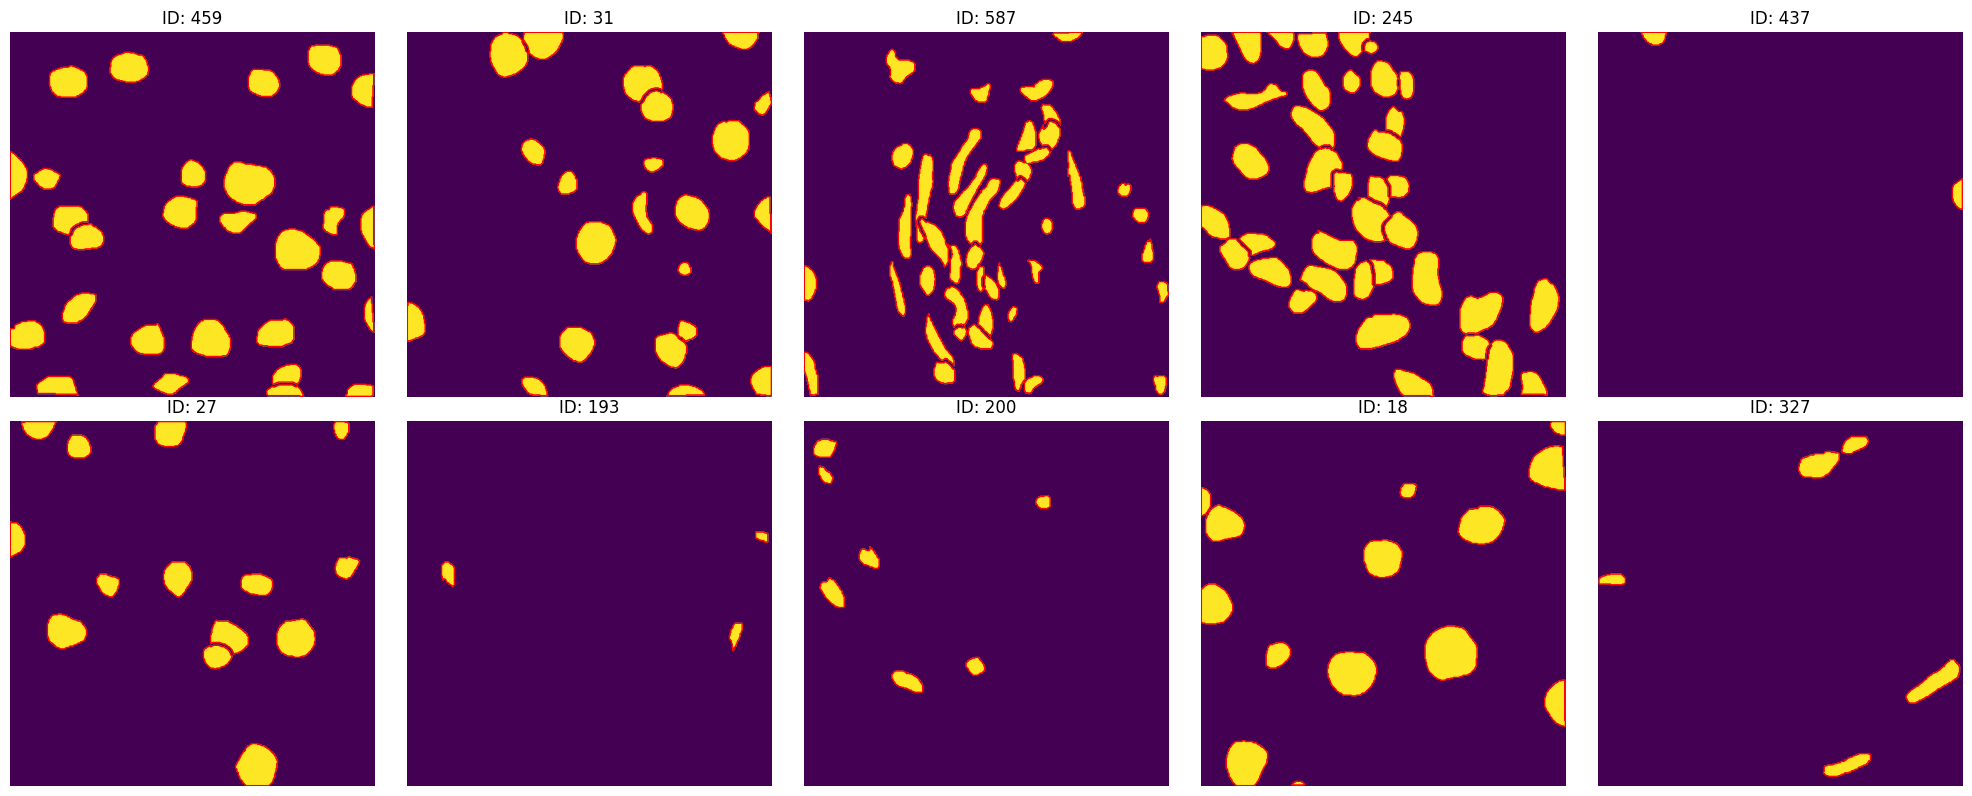

In [14]:
# Randomly select 10 images
random_images = random.sample(coco_data['images'], 10)

# Create a plot with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

# Visualize each selected image and its annotations
for ax, img_data in zip(axs, random_images):
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax)

plt.tight_layout()
plt.show()


---

**Print JSON File Lines**

---

In [15]:
# Print the first few lines of the coco_annotations.json file
with open('coco_annotations.json', 'r') as f:
    for _ in range(24):  # Adjust the number of lines as needed
        print(f.readline().strip())


{
"images": [
{
"id": 1,
"file_name": "mouse_liver_23.png",
"height": 512,
"width": 512
},
{
"id": 2,
"file_name": "mouse_liver_22.png",
"height": 512,
"width": 512
},
{
"id": 3,
"file_name": "mouse_liver_21.png",
"height": 512,
"width": 512
},
{
"id": 4,
"file_name": "mouse_liver_17.png",
"height": 512,


---

**Print Polygon Coordinates**

---

In [16]:
# Function to print the polygon coordinates for a random image
def print_polygon_coordinates(image_data, annotations):
    print(f"Image ID: {image_data['id']}, File Name: {image_data['file_name']}")
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            print(f"  Annotation ID: {ann['id']}, Polygon Coordinates: {ann['segmentation'][0]}")


In [17]:
# Print polygon coordinates for the 10 random images
for img_data in random_images:
    image_id = img_data['id']
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
    print_polygon_coordinates(img_data, annotations)

Image ID: 459, File Name: human_liver_40.png
  Annotation ID: 17359, Polygon Coordinates: [377, 495, 376, 496, 374, 496, 373, 497, 372, 497, 371, 498, 370, 498, 369, 497, 368, 497, 367, 498, 366, 498, 364, 500, 363, 500, 362, 501, 361, 501, 361, 502, 360, 503, 360, 508, 361, 509, 361, 510, 406, 510, 407, 511, 412, 511, 411, 510, 411, 508, 410, 507, 410, 506, 409, 505, 409, 504, 408, 503, 408, 502, 403, 497, 402, 497, 401, 498, 400, 497, 399, 497, 398, 496, 397, 496, 396, 495]
  Annotation ID: 17360, Polygon Coordinates: [483, 494, 482, 495, 481, 495, 479, 497, 478, 497, 473, 502, 473, 507, 471, 509, 471, 511, 507, 511, 509, 509, 509, 496, 507, 496, 506, 495, 500, 495, 499, 494]
  Annotation ID: 17361, Polygon Coordinates: [53, 483, 52, 484, 51, 484, 49, 486, 48, 486, 46, 488, 45, 488, 43, 490, 42, 490, 37, 495, 37, 501, 38, 502, 38, 507, 63, 507, 64, 508, 92, 508, 93, 509, 95, 509, 95, 508, 94, 507, 94, 505, 93, 504, 93, 503, 92, 502, 92, 498, 91, 497, 91, 496, 90, 495, 90, 493, 89, 49

## 4. Organize Image Data

---

**Split your images and annotations into training and validation sets.**

---

In [18]:
# Function to split dataset into training and validation
def split_dataset(coco_data, split_ratio=0.8):
    # Randomly shuffle the images
    images = coco_data['images']
    random.shuffle(images)

    # Split images into train and validation sets
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Get image IDs for the split
    train_image_ids = {img['id'] for img in train_images}
    val_image_ids = {img['id'] for img in val_images}

    # Filter annotations based on the split image IDs
    train_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in train_image_ids]
    val_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in val_image_ids]

    # Create split data
    train_data = {
        'images': train_images,
        'annotations': train_annotations,
        'categories': coco_data['categories']
    }

    val_data = {
        'images': val_images,
        'annotations': val_annotations,
        'categories': coco_data['categories']
    }

    return train_data, val_data

# Split the dataset
train_data, val_data = split_dataset(coco_data, split_ratio=0.8)


---

**Create COCO Annotation Files for Train and Validation Sets**

---

In [19]:
# Define paths for the new COCO annotation files
train_annotation_path = 'train2017.json'
val_annotation_path = 'val2017.json'

# Save the annotations to JSON files
with open(train_annotation_path, 'w') as f:
    json.dump(train_data, f, indent=4)

with open(val_annotation_path, 'w') as f:
    json.dump(val_data, f, indent=4)

# Create directories for train and val datasets
os.makedirs('train2017', exist_ok=True)
os.makedirs('val2017', exist_ok=True)

# Function to move images to their respective directories
def move_images(data, image_paths, target_dir):
    for image in data['images']:
        image_file = image['file_name']
        if image_file in image_paths:
            source_path = image_paths[image_file]
            target_path = os.path.join(target_dir, image_file)
            shutil.move(source_path, target_path)
        else:
            print(f"Image {image_file} does not exist in image_paths and cannot be moved.")

# Move images to train2017 and val2017 directories
move_images(train_data, image_paths, 'train2017')
move_images(val_data, image_paths, 'val2017')


---

**Visualizar 10 imagenes de cada directorio (train2017 y val2017) para comprobar.**

---

In [20]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.patches import Polygon

# Load COCO annotations for train and val sets
with open('train2017.json') as f:
    train_coco_data = json.load(f)

with open('val2017.json') as f:
    val_coco_data = json.load(f)

# Create dictionaries to map image IDs and file names to image data
train_file_name_to_data = {img['file_name']: img for img in train_coco_data['images']}
val_file_name_to_data = {img['file_name']: img for img in val_coco_data['images']}

# Function to get image path
def get_image_path(file_name, base_directory):
    return os.path.join(base_directory, file_name)


In [21]:
# Function to visualize a single image with annotations
def visualize_image(image_data, annotations, ax, base_directory):
    file_name = image_data['file_name']
    img_path = get_image_path(file_name, base_directory)

    if not os.path.isfile(img_path):
        print(f"Image file {file_name} not found.")
        return

    # Load the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Overlay annotations
    for ann in annotations:
        if ann['image_id'] == image_data['id']:
            # Draw polygons
            polygon = np.array(ann['segmentation'][0]).reshape(-1, 2)
            poly = Polygon(polygon, facecolor='none', edgecolor='r')
            ax.add_patch(poly)

    ax.set_title(f"ID: {image_data['id']}")


In [22]:
import random

# Function to select random images and their annotations
def get_random_images_and_annotations(coco_data, num_images=10):
    images = coco_data['images']
    random_images = random.sample(images, num_images)
    image_ids = {img['id'] for img in random_images}
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in image_ids]
    return random_images, annotations

# Select random images from train and val datasets
train_images, train_annotations = get_random_images_and_annotations(train_coco_data, num_images=10)
val_images, val_annotations = get_random_images_and_annotations(val_coco_data, num_images=10)


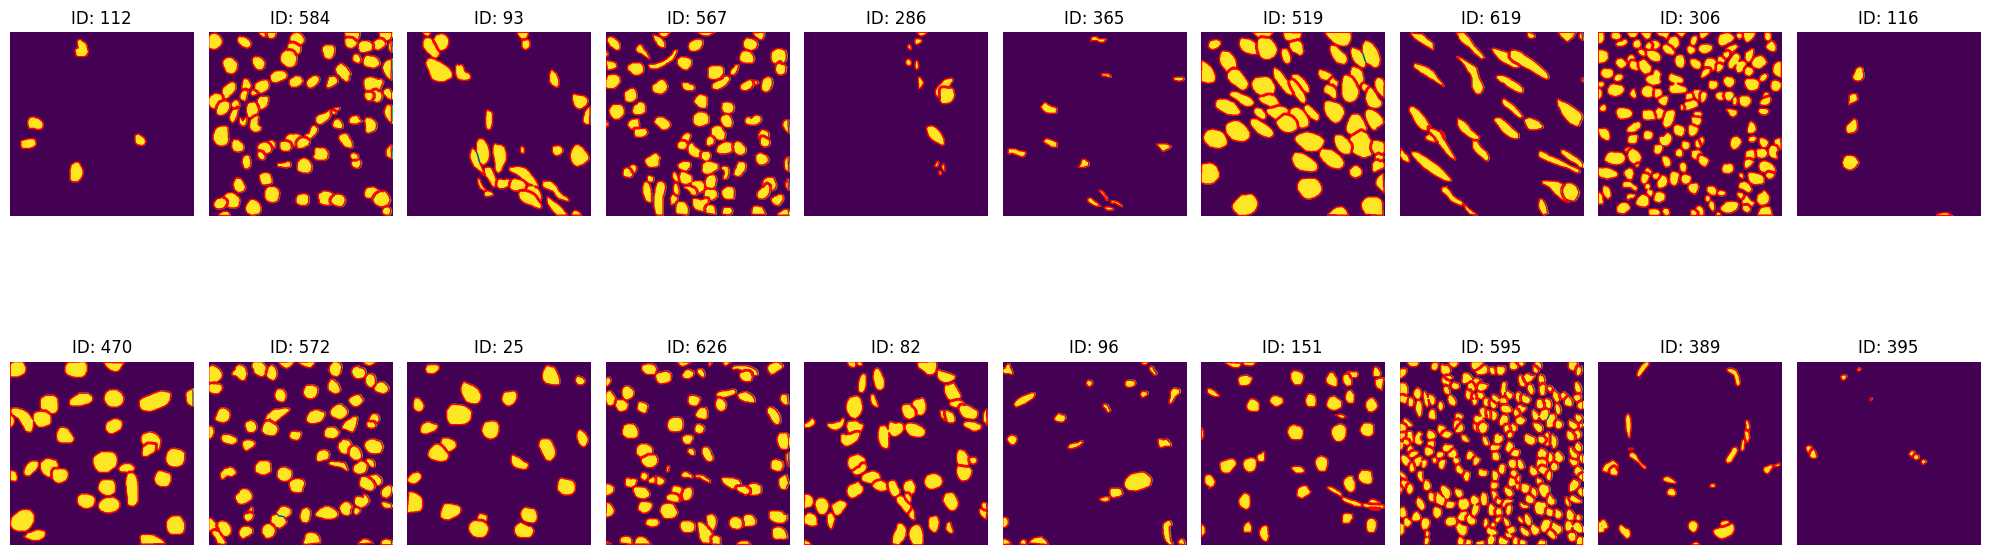

In [23]:
# Set base directories for train and val images
train_base_directory = 'train2017'
val_base_directory = 'val2017'

# Plot images from train and validation sets
fig, axs = plt.subplots(2, 10, figsize=(20, 8))

# Plot train images
for ax, img_data in zip(axs[0], train_images):
    image_id = img_data['id']
    annotations = [ann for ann in train_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax, train_base_directory)

# Plot val images
for ax, img_data in zip(axs[1], val_images):
    image_id = img_data['id']
    annotations = [ann for ann in val_annotations if ann['image_id'] == image_id]
    visualize_image(img_data, annotations, ax, val_base_directory)

plt.tight_layout()
plt.show()


In [24]:
import os

# List files in the train2017 and val2017 directories
train_files = os.listdir(train_base_directory)
val_files = os.listdir(val_base_directory)

print("Files in train2017 directory:")
print(train_files[:10])  # Print first 10 files for quick checking

print("Files in val2017 directory:")
print(val_files[:10])  # Print first 10 files for quick checking


Files in train2017 directory:
['mouse_subscapula_42.png', 'human_testis_3.png', 'human_kidney_03.png', 'human_spleen_07.png', 'mouse_liver_23.png', 'human_oesophagus_34.png', 'human_cerebellum_3.png', 'human_salivory_33.png', 'mouse_kidney_28.png', 'mouse_spleen_02.png']
Files in val2017 directory:
['mouse_subscapula_02.png', 'mouse_muscle_tibia_09.png', 'human_jejunum_10.png', 'mouse_liver_22.png', 'human_rectum_1.png', 'human_placenta_24.png', 'human_muscle_1.png', 'human_lung_4.png', 'mouse_liver_17.png', 'human_oesophagus_11.png']


---

**Update train2017 and val2017 json files**

---

In [25]:
import json
import os

# Function to update image paths in COCO annotation data
def update_image_paths(data, new_base_dir):
    for image_info in data['images']:
        image_info['file_name'] = os.path.join(new_base_dir, image_info['file_name'])
    return data

# Load the annotations
with open('train2017.json', 'r') as f:
    train_data = json.load(f)

with open('val2017.json', 'r') as f:
    val_data = json.load(f)

# Update the image paths in the JSON data
train_data = update_image_paths(train_data, 'train2017')
val_data = update_image_paths(val_data, 'val2017')

# Save the updated annotations back to JSON files
with open('train2017.json', 'w') as f:
    json.dump(train_data, f, indent=4)

with open('val2017.json', 'w') as f:
    json.dump(val_data, f, indent=4)

print("Image paths in train2017.json and val2017.json have been updated.")


Image paths in train2017.json and val2017.json have been updated.


In [7]:
# Print the first few lines of the train2017.json  and val2017.json file
with open('train2017.json', 'r') as f:
    for _ in range(24):  # Adjust the number of lines as needed
        print(f.readline().strip())

{
"images": [
{
"id": 573,
"file_name": "train2017/human_salivory_22.png",
"height": 512,
"width": 512
},
{
"id": 604,
"file_name": "train2017/human_pancreas_15.png",
"height": 512,
"width": 512
},
{
"id": 567,
"file_name": "train2017/human_salivory_08.png",
"height": 512,
"width": 512
},
{
"id": 587,
"file_name": "train2017/human_salivory_15.png",
"height": 512,


In [10]:
import json
import os

def check_image_paths(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    for image in data['images']:
        file_path = image['file_name']
        if not os.path.isfile(file_path):
            print(f"Missing file: {file_path}")

# Check paths in train2017.json and val2017.json
check_image_paths('train2017.json')
check_image_paths('val2017.json')



---

**Display 10 images for both sets to validate update**

---

Displaying 10 images from train2017 



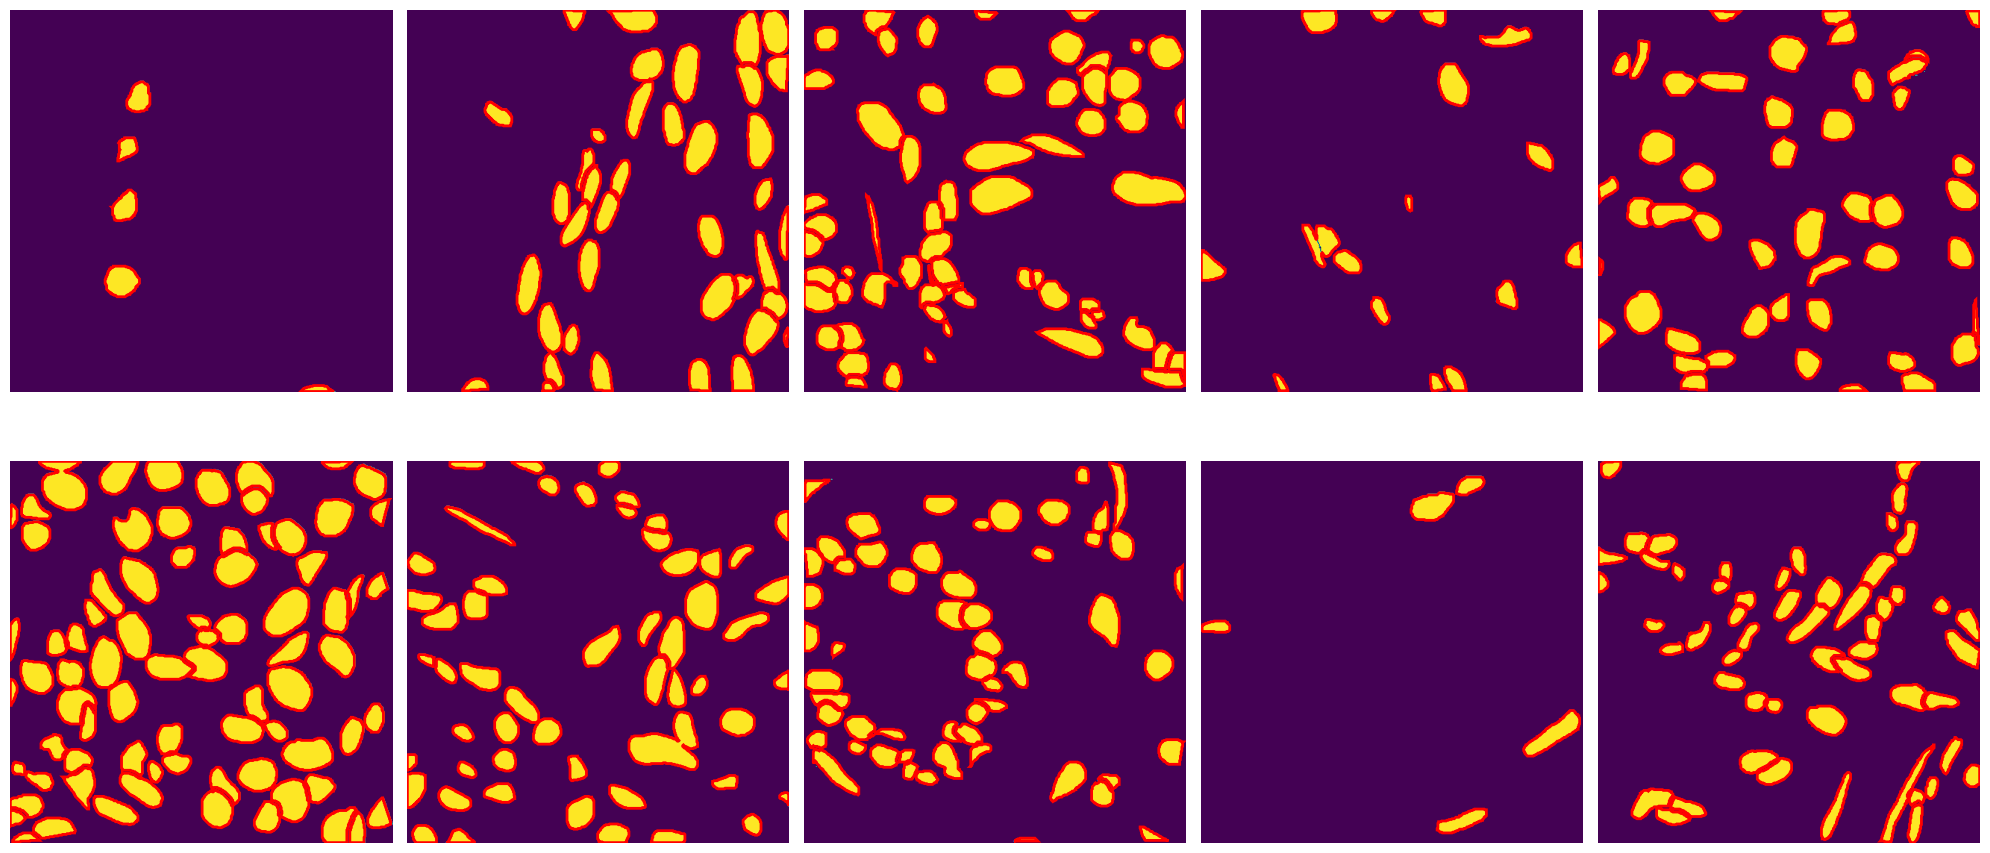


 Displaying 10 images from val2017 



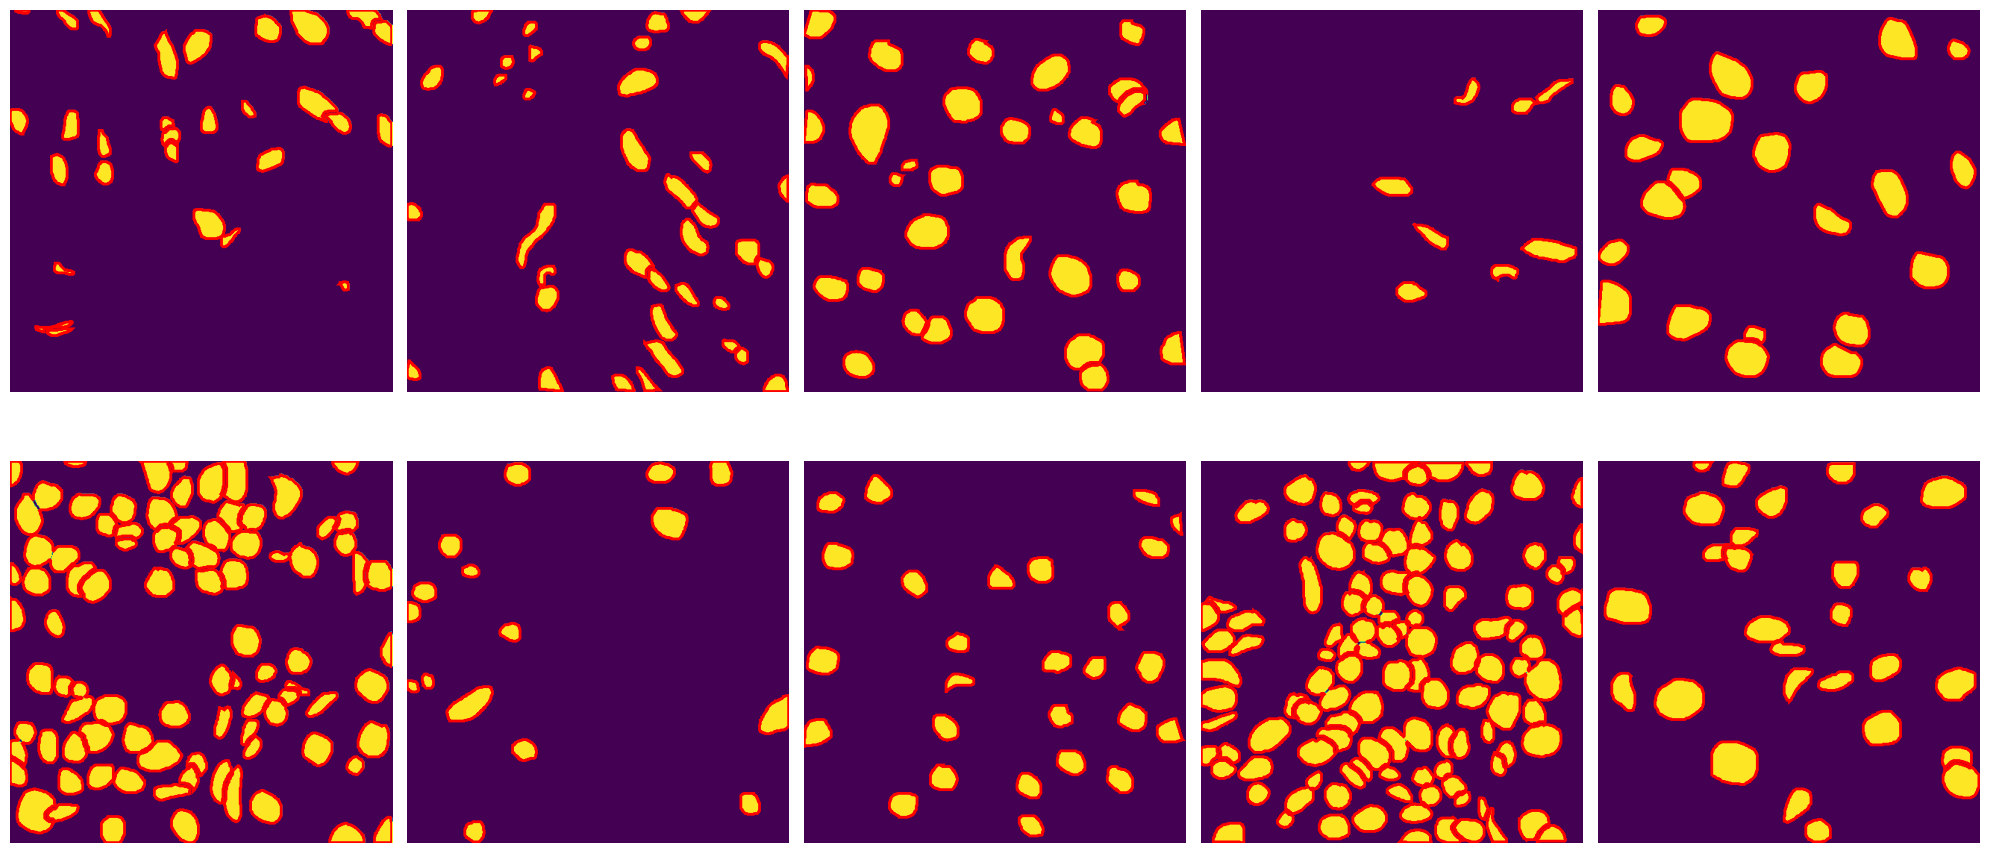

In [11]:
import json
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image

# Function to load COCO annotations
def load_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
        return json.load(f)

# Function to display images with annotations in a grid
def display_images_with_annotations(data, num_images=10, rows=2, cols=5):
    # Select random images
    images = random.sample(data['images'], num_images)

    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
    axs = axs.flatten()

    for ax, image_info in zip(axs, images):
        image_path = image_info['file_name']

        # Open image
        image = Image.open(image_path)

        # Get annotations for the image
        annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_info['id']]

        # Display image
        ax.imshow(image)
        ax.axis('off')

        # Plot annotations
        for ann in annotations:
            # Assuming the annotations are polygons
            if 'segmentation' in ann:
                for seg in ann['segmentation']:
                    poly = Polygon(np.array(seg).reshape(-1, 2), closed=True, edgecolor='r', fill=False, linewidth=2)
                    ax.add_patch(poly)

    plt.tight_layout()
    plt.show()

# Load the updated annotations
train_data = load_annotations('train2017.json')
val_data = load_annotations('val2017.json')

# Display 10 images with annotations from train2017 in a grid
print("Displaying 10 images from train2017 \n")
display_images_with_annotations(train_data, num_images=10, rows=2, cols=5)

# Display 10 images with annotations from val2017 in a grid
print("\n Displaying 10 images from val2017 \n")
display_images_with_annotations(val_data, num_images=10, rows=2, cols=5)


## 5. Fine-tune Mask R-CNN for medical instance segmentation

First, install Detectron2 and other necessary dependencies

---
**Set up the environment**

---

In [1]:
!pip install -q torch torchvision
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q opencv-python
!pip install -q matplotlib

  Preparing metadata (setup.py) ... done



Use a Python script to configure and train the Mask R-CNN model with detectron2.

---
**Configure the Mask R-CNN model**

---

In [22]:
import os
import json
import random
import numpy as np
import cv2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances

# Register COCO datasets
register_coco_instances("nuclei_train", {}, "train2017.json", "train2017")
register_coco_instances("nuclei_val", {}, "val2017.json", "val2017")

# Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nuclei_train",)
cfg.DATASETS.TEST = ("nuclei_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000    # Adjust this as needed
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (e.g., Nucleus)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Save the final weights
final_weights_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
torch.save(trainer.model.state_dict(), final_weights_path)


[07/20 09:10:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/20 09:10:31 d2.engine.train_loop]: Starting training from iteration 0
ERROR [07/20 09:10:31 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/usr/local/lib/python3.10/dist-packages/detectron2/engine/defaults.py", line 498, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.10/dist-packages/detectron2/engine/train_loop.py", line 297, in run_step
    data = next(self._data_loader_iter)
  File "/usr/local/lib/python3.10/dist-packages/detectron2/data/common.py", line 329, in __iter__
    for d in self.dataset:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1346, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/p

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
  File "/usr/local/lib/python3.10/dist-packages/detectron2/data/common.py", line 296, in __iter__
    yield self.dataset[idx]
  File "/usr/local/lib/python3.10/dist-packages/detectron2/data/common.py", line 125, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
  File "/usr/local/lib/python3.10/dist-packages/detectron2/utils/serialize.py", line 26, in __call__
    return self._obj(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/detectron2/data/dataset_mapper.py", line 154, in __call__
    image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
  File "/usr/local/lib/python3.10/dist-packages/detectron2/data/detection_utils.py", line 180, in read_image
    with PathManager.open(file_name, "rb") as f:
  File "/usr/local/lib/python3.10/dist-packages/iopath/common/file_io.py", line 1012, in open
    bret = handler._open(path, mode, buffering=buffering, **kwargs)  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/iopath/common/file_io.py", line 604, in _open
    return open(  # type: ignore
FileNotFoundError: [Errno 2] No such file or directory: 'train2017/train2017/mouse_muscle_tibia_13.png'


---
**Evaluate the model**

---

In [ ]:
# Load the trained model
cfg.MODEL.WEIGHTS = final_weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Evaluate the model on the validation dataset
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("nuclei_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "nuclei_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


---
**Visualize Results**

---

In [ ]:
dataset_dicts = DatasetCatalog.get("nuclei_val")

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get("nuclei_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow("Result", out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
!pip install -q pycocotools

---

import os
import copy
import random
import json
import glob
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from   zipfile import ZipFile
import argparse
import shutil


from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.utils.data
from torch import nn
import torchvision


from torchvision import transforms as T

from pycocotools import mask as coco_mask
from pycocotools.coco import COCO


"""
Data Preparation


Clean up of the Nuclei dataset
Can be downloaded from: https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download

The dataset comes with a lot of subdirectories that can be very useful depending
on the task of your interest. For our Mask RCNN and Ultralytics training, we just
need the raw images and labeled masks that we will convert to appropriate formats.
So let us delete all unwanted data and keep only the raw images, binary masks
and label masks.

Keep the directories with names 'tissue images', 'mask binary without border', and 'label masks modify'

"""


def prune_subdirectories(base_dir,keep_dirs):
    #Iterate through each subdirs in base dir
    for root_dir in os.listdir(base_dir):
        root_path = os.path.join(base_dir,root_dir)
        if os.path.isdir(root_path):
          #  print(f"Processing: {root_path}")
           #List all subdirs inside the current root dir
           for sub_dir in os.listdir(root_path):
               sub_path = os.path.join(root_path, sub_dir)
               #If the subdirectory isn't in the keep list, delete it
               if os.path.isdir(sub_path) and sub_dir not in keep_dirs:
                  # print(f"Deleting: {sub_path}")
                  shutil.rmtree(sub_path)
               elif os.path.isdir(sub_path):
                  # print(f"Keeping: {sub_path}")
                  pass


base_directory = "Dataset-Nuclei"
directories_to_keep = ['tissue images', 'mask binary witthout border', 'label masks modify']

prune_subdirectories(base_directory,directories_to_keep)




---


# Install Pip Tree globally
%%capture
!sudo apt install tree


!tree --dirsfirst -L 2  "Dataset-Nuclei"

Dataset-Nuclei
├── human bladder
│   ├── label masks modify
│   └── tissue images
├── human brain
│   ├── label masks modify
│   └── tissue images
├── human cardia
│   ├── label masks modify
│   └── tissue images
├── human cerebellum
│   ├── label masks modify
│   └── tissue images
├── human epiglottis
│   ├── label masks modify
│   └── tissue images
├── human jejunum
│   ├── label masks modify
│   └── tissue images
├── human kidney
│   ├── label masks modify
│   └── tissue images
├── human liver
│   ├── label masks modify
│   └── tissue images
├── human lung
│   ├── label masks modify
│   └── tissue images
├── human melanoma
│   ├── label masks modify
│   └── tissue images
├── human muscle
│   ├── label masks modify
│   └── tissue images
├── human oesophagus
│   ├── label masks modify
│   └── tissue images
├── human pancreas
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── human peritoneum
│   ├── label masks modify
│   └── tissue images
├── human placenta
│   ├── label masks modify
│   └── tissue images
├── human pylorus
│   ├── label masks modify
│   └── tissue images
├── human rectum
│   ├── label masks modify
│   └── tissue images
├── human salivory gland
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── human spleen
│   ├── label masks modify
│   └── tissue images
├── human testis
│   ├── label masks modify
│   └── tissue images
├── human tongue
│   ├── label masks modify
│   └── tissue images
├── human tonsile
│   ├── label masks modify
│   └── tissue images
├── human umbilical cord
│   ├── label masks modify
│   └── tissue images
├── mouse fat (white and brown)_subscapula
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── mouse femur
│   ├── label masks modify
│   └── tissue images
├── mouse heart
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── mouse kidney
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── mouse liver
│   ├── label masks modify
│   └── tissue images
├── mouse muscle_tibia
│   ├── label masks modify
│   └── tissue images
├── mouse spleen
│   ├── label masks modify
│   └── tissue images
└── mouse thymus
    ├── label masks modify
    └── tissue images

93 directories, 5 files
#Convert Label Masks to Coco Json Single File annotation

"""
With this code, we will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

"""
def get_image_mask_pairs(data_dir):
    image_paths = []
    mask_paths = []

    for root,_,files in os.walk(data_dir):
        if 'tissue images' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root,file))
                    mask_paths.append(os.path.join(root.replace('tissue images','label masks modify'), file.replace('.png','.tif')))
    return image_paths, mask_paths

def mask_to_polygons(mask,epsilon=1.0):
    contours,_ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
           poly = contour.reshape(-1).tolist()
           if len(poly) > 4: #Ensures valid polygon
              polygons.append(poly)
    return polygons





def process_data(image_paths, mask_paths, output_dir,train=True):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))

        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })

        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:  # Ignore background
                continue

            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)

            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Nuclei
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })

    coco_input = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "Nuclei"}]
    }

    if train:
        with open(os.path.join(output_dir, 'instances_train2017.json'), 'w') as f:
            json.dump(coco_input, f)
    else:
        with open(os.path.join(output_dir, 'instances_val2017.json'), 'w') as f:
            json.dump(coco_input, f)

#instances_train2017.json
def main():
    data_dir = 'Dataset-Nuclei'
    output_dir = 'Nuclei_Instance_COCO_input'
    train_dir = os.path.join(output_dir, 'train2017') #we will stick with naming from official repo scripts
    val_dir = os.path.join(output_dir, 'val2017')

    # Create output directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    image_paths, mask_paths = get_image_mask_pairs(data_dir)

    # Split data into train and val
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

    # Process train and val data
    process_data(train_img_paths, train_mask_paths, train_dir,train=True)
    process_data(val_img_paths, val_mask_paths, val_dir,train=False)

if __name__ == '__main__':
    main()
!mkdir ./Nuclei_Instance_COCO_input/annotations
!mv ./Nuclei_Instance_COCO_input/train2017/instances_train2017.json  ./Nuclei_Instance_COCO_input/annotations/
!mv ./Nuclei_Instance_COCO_input/val2017/instances_val2017.json  ./Nuclei_Instance_COCO_input/annotations/

!mkdir -p ./Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out
!mkdir -p ./Nuclei_Instance_COCO_input/outputs/inference/nuclei_instance_out
!tree --dirsfirst -L 1 "Nuclei_Instance_COCO_input"
Nuclei_Instance_COCO_input
├── annotations
├── outputs
├── train2017
└── val2017

4 directories, 0 files
!tree --dirsfirst -L 1 "Nuclei_Instance_COCO_input/annotations"
Nuclei_Instance_COCO_input/annotations
├── instances_train2017.json
└── instances_val2017.json

0 directories, 2 files
Visualise Coco Label - Dataset visualise - Only Contours


def display_images_with_coco_annotations(image_paths, annotations, display_type='both', filled=True):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        green_color = (0, 0,1)  # RGB for green

        for ann in img_annotations:
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                         linewidth=1, edgecolor=green_color,
                                         facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    if filled == False:
                        polygon = patches.Polygon(poly, closed=True, edgecolor=green_color, fill=False)
                    else:
                        polygon = patches.Polygon(poly, closed=True, edgecolor=green_color, fill=True, facecolor=green_color, alpha=0.7)

                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()
# Load COCO annotations
with open('Nuclei_Instance_COCO_input/annotations/instances_train2017.json','r') as f:
     annotations = json.load(f)

# Get all image files
image_dir = "Nuclei_Instance_COCO_input/train2017"
all_images_files = [os.path.join(image_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_images_files,4)

# Choose between 'bbox', 'seg', or 'both'
display_type = "seg"
display_images_with_coco_annotations(random_image_files,annotations,display_type,fil

























From torchvision download training scripts for detection that we will be using for training Mask RCNN:
https://github.com/pytorch/vision/tree/main/references/detection

Create folder scripts in current working directory of colab and have these torchvision scripts.


In [ ]:

class_names = """
INSTANCE_CATEGORY_NAMES = [
    '__background__',
    'Nuclei',
]
"""

with open('class_names.py', 'w') as file:
    file.write(class_names)


!tree --dirsfirst -L 2 ".."
..
├── Nuclei_Instance_COCO_input
│   ├── annotations
│   ├── outputs
│   ├── train2017
│   └── val2017
├── scripts
│   ├── class_names.py
│   ├── coco_eval.py
│   ├── coco_utils.py
│   ├── engine.py
│   ├── group_by_aspect_ratio.py
│   ├── presets.py
│   ├── train.py
│   ├── transforms.py
│   └── utils.py
└── nuinsseg.zip

6 directories, 10 files

'''In train.py script change the following :'''

#train.py

import torch.nn as nn
from class_names import INSTANCE_CATEGORY_NAMES as class_names

#Next  to this line
model = torchvision.models.get_model(
        args.model, weights=args.weights, weights_backbone=args.weights_backbone, num_classes=num_classes, **kwargs
    )
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(class_names),bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=len(class_names)*4,bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, len(class_names),kernel_size=(1,1),stride=(1,1))

model.to(device)





In [ ]:

!python train.py \
--data-path ../Nuclei_Instance_COCO_input \
--model maskrcnn_resnet50_fpn_v2 \
--weights MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1 \
--batch-size 4 \
--epochs 10 \
--lr 0.005 \
--output-dir ../Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out \
--amp \
--lr-steps 10 \
--data-augmentation lsj \
--use-copypaste \
--workers 0



INFERENCE


In [ ]:

model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=False)

from class_names import INSTANCE_CATEGORY_NAMES as class_names

model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024,out_features=len(class_names),bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024,out_features=len(class_names)*4,bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256,len(class_names),kernel_size=(1,1),stride=(1,1))
OUT_DIR = "../Nuclei_Instance_COCO_input/outputs"
# ckpt = torch.load(os.path.join(OUT_DIR,"training/nuclei_instance_out/checkpoint.pth"))
ckpt = torch.load("../Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out/checkpoint.pth")
model.load_state_dict(ckpt['model'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()
print(model)
np.random.seed(0)

def get_outputs(image, model, threshold):
    # print("Get out Image shape",image.shape)
    with torch.no_grad():
        # forward pass of the image through the model.
        outputs = model(image)

    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]

    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [class_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels
np.random.seed(0)

def get_outputs(image, model, threshold):
    # print("Get out Image shape",image.shape)
    with torch.no_grad():
        # forward pass of the image through the model.
        outputs = model(image)

    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]

    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [class_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels
def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1.0
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    #convert the original PIL image into NumPy format
    image = np.array(image)
    # convert from RGN to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        # apply a random color mask to each object
        color = [random.randint(0, 255) for _ in range(3)]
        if masks[i].any() == True:
            red_map = np.zeros_like(masks[i]).astype(np.uint8)
            green_map = np.zeros_like(masks[i]).astype(np.uint8)
            blue_map = np.zeros_like(masks[i]).astype(np.uint8)
            red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1] = color
            # combine all the masks into a single image
            segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
            # apply mask on the image
            cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)

            # draw the bounding boxes around the objects
            cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color,
                        thickness=2)
            # put the label text above the objects
            # cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10),
            #             cv2.FONT_HERSHEY_SIMPLEX, 1, color,
            #             thickness=2, lineType=cv2.LINE_AA)
    return image
validation_path = "../Nuclei_Instance_COCO_input/val2017"
image_paths = glob.glob(os.path.join(validation_path,'*png'))
transform = T.Compose([
    T.ToTensor()
])

fig = plt.figure(figsize=(10,25),layout="constrained")

for image_path in image_paths:
    # print(image_path)
    image = Image.open(image_path).convert("RGB")
    # keep a copy of the original image for OpenCV functions and applying masks
    orig_image = image.copy()

    image = transform(image)
    #add a batch dimension
    image = image.unsqueeze(0).to(device)
    # print("Image shape",image.shape)

    masks,boxes,labels = get_outputs(image,model,threshold=0.5)

    result = draw_segmentation_map(orig_image,masks,boxes,labels)

    save_path = f"{OUT_DIR}/inference/nuclei_instance_out{image_path.split(os.path.sep)[-1].split('.')[0]}.jpg"
    cv2.imwrite(save_path, result)

    #visualise images
    plt.imshow(result)
    plt.axis('off')

plt.show()